# Covid19 Image Classification - Phase 2  

__Abstract:__ Our Aim is to detect Covid19 from chest X-rays. The covid19 image dataset is small with 251 training and 60 test images belonging to 'NoFinding', 'Covid19' and 'Pneumonia' respectively. This dataset small and is insufficient to generalize. So for the purpoe of our project, in Phase-I we will first use NIH X-ray image data to retrain and finetune pretrained model architecture such as ResNet50V2, MobileNetV2 and VGG16.

Following the results from phase 1, we selected the best model to be ______ and in phase2 we will focus on classifing our target dataset of covid images

In [1]:
# common imports
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
from pathlib import Path
from functools import partial

from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#change working directory  - as the images are located in data/raw in the project folder (Execute this cell Once)
os.chdir("../")

In [3]:
# Import functions for trianing the model
%load_ext autoreload
%autoreload 2
import src.models.train_model as train_model

# load tensorboard extension
%reload_ext tensorboard

In [4]:
# Constants
SEED =42
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
TARGET_WIDTH= 224
TARGET_HEGIHT =224
NUM_CLASSES = 3 # number of ClassesNUM
NUM_EPOCHS = 10
log_folder = 'logs' # logs folder

## Preprocess Images

In [5]:
BATCH_SIZE =1

covid_image_train_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split=0.2,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]


covid_image_test_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]




covid_train_generator = covid_image_train_data_gen.flow_from_directory(
  'data/raw/Covid19-dataset/train',
  subset="training",
  class_mode='categorical',
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

covid_valid_generator = covid_image_train_data_gen.flow_from_directory(
  'data/raw/Covid19-dataset/train/',
  subset="validation",
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  class_mode='categorical',
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

covid_test_generator = covid_image_test_data_gen.flow_from_directory(
  'data/raw/Covid19-dataset/test/',
  class_mode='categorical',
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Reload and train the Saved Model

Epoch 1/2
6/6 [==============================] - 3s 166ms/step - loss: 1.4454 - accuracy: 0.0000e+00 - val_loss: 1.1768 - val_accuracy: 0.0000e+00
Epoch 2/2
6/6 [==============================] - 0s 80ms/step - loss: 1.4591 - accuracy: 0.1667 - val_loss: 1.0755 - val_accuracy: 1.0000
Best Model Accuracy and Loss plots


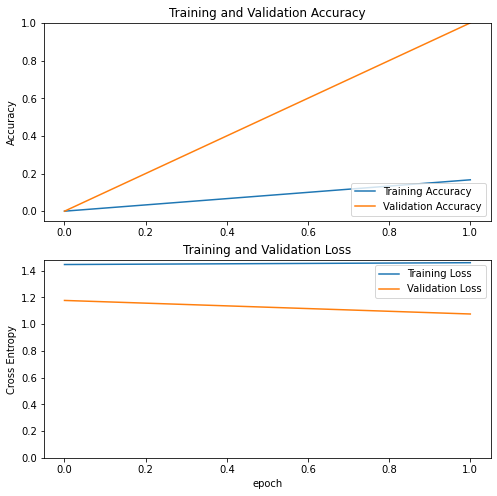





Fine-Tuned Best Model Training and Validation: 
Epoch 1/2
6/6 [==============================] - 3s 152ms/step - loss: 1.1412 - accuracy: 0.5000 - val_loss: 1.1082 - val_accuracy: 0.0000e+00
Epoch 2/2
6/6 [==============================] - 0s 80ms/step - loss: 0.9864 - accuracy: 0.3333 - val_loss: 1.1118 - val_accuracy: 0.0000e+00
Fine-Tuned Best Model Accuracy and Loss plots


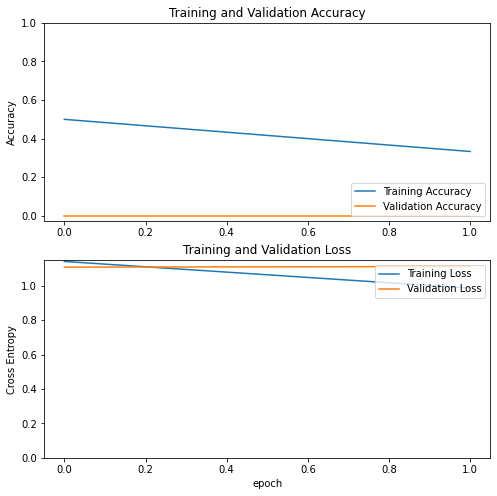

In [8]:
freeze_layers = True
model_name = "Best Model"
num_classes =14
activation ='softmax'
learning_rate = 0.0001
fine_tune_at_layer = 178

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("models/my-model")
new_layer = reconstructed_model.layers[-2].output
output = keras.layers.Dense(NUM_CLASSES, activation='softmax')(new_layer)
new_model = keras.Model(inputs = reconstructed_model.input, outputs = output)
new_model = train_model.compile_classifier(new_model, learning_rate)
new_model_history = train_model.fit_model(new_model, covid_train_generator, covid_valid_generator,num_epochs=2,batch_size=32)

print(f'{model_name} Accuracy and Loss plots')
train_model.plot_accuracy_and_loss(new_model_history)


print("\n")
#fine_tune model_name
new_model_ft = train_model.fine_tune_model(new_model,learning_rate,optimizer='Adam',fine_tune_at_layer=fine_tune_at_layer)
    
print("\n")
print(f'Fine-Tuned {model_name} Training and Validation: ')
new_model_ft_history = train_model.fit_model(new_model_ft, covid_train_generator, 
        covid_valid_generator, 
        num_epochs=NUM_EPOCHS)

print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
train_model.plot_accuracy_and_loss(new_model_ft_history)